In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
len(df)

11914

In [3]:
df.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


# Normalization

In [4]:
# Normalization of column names
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Filtering columns with object dtypes
string_columns = list(df.dtypes[df.dtypes == 'object'].index)

# Normalizing them for consistency
for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

# Exploratory data analysis

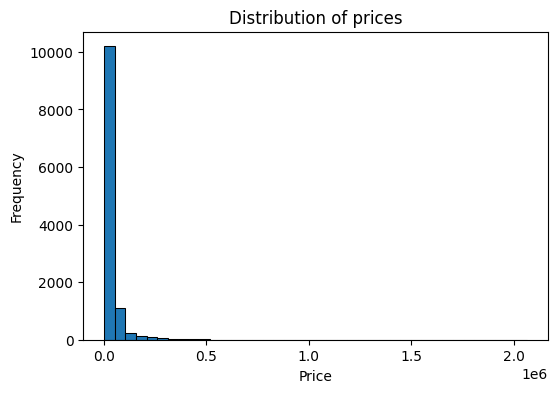

In [5]:
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp, bins=40, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

#### Concised view

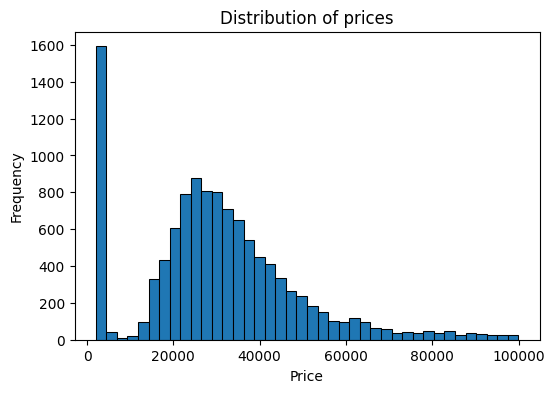

In [6]:
plt.figure(figsize=(6, 4))

sns.histplot(df.msrp[df.msrp < 100000], bins=40, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Price')
plt.title('Distribution of prices')

plt.show()

# Transformation of Data

In [7]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## using Logarithmic Transformation on prices column

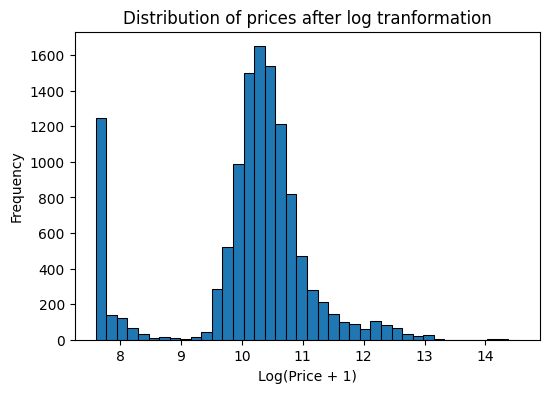

In [8]:
log_price = np.log1p(df.msrp)

plt.figure(figsize=(6, 4))

sns.histplot(log_price, bins=40, alpha=1)
plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Distribution of prices after log tranformation')

plt.show()

## we will require only numerical data types for machine learning model. So for simplicity let's keep only numerical type columns

In [9]:
df = df.select_dtypes(include = ['int64','float64'])

In [10]:
df.isnull().sum()

year                 0
engine_hp           69
engine_cylinders    30
number_of_doors      6
highway_mpg          0
city_mpg             0
popularity           0
msrp                 0
dtype: int64

very small portion of data points contain missing values so we drop those rows

In [11]:
df = df.fillna(0)

In [12]:
df.isnull().sum()

year                0
engine_hp           0
engine_cylinders    0
number_of_doors     0
highway_mpg         0
city_mpg            0
popularity          0
msrp                0
dtype: int64

# Setting up validation framework

In [13]:
np.random.seed(2)

## Shuffling data

In [14]:
n = len(df)

n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

In [15]:
idx = np.arange(n)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

## 60+20+20 Train+Validation+Test set

In [16]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

In [17]:
y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

In [18]:
log_y_train = np.log1p(df_train.msrp.values)
log_y_val = np.log1p(df_val.msrp.values)
log_y_test = np.log1p(df_test.msrp.values)

In [19]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

# Modelling

## Simple Linear Regression

As a starting point let's predefine the weights and bias of a linear regression model

In [20]:
df_train.head()

,year,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity
2735,2008,148.0,4.0,2.0,33,24,1385
6720,2012,132.0,4.0,4.0,32,25,2031
5878,2016,148.0,4.0,4.0,37,28,640
11190,1991,90.0,4.0,3.0,18,16,873
4554,2017,385.0,8.0,4.0,21,15,5657


In [21]:
X_train = df_train.to_numpy()

In [22]:
def dummy_linear_regression(X):
    w0 = 2 # bias as 2
    wts = np.ones((X.shape[1], 1)) # for simplysity we keep all weights =1

    # Calculating price w0 + w1*x1 + w2*x2 + ....+ wn*xn using matrix multiplication
    pred = w0 + X@wts;    
    return pred
    

### lets test it directly. As we have pre computed model

In [23]:
dummy_linear_regression(X_train)

array([[3606.],
       [4242.],
       [2879.],
       ...,
       [2900.],
       [2715.],
       [3153.]], shape=(7150, 1))

## Actual Training of Linear Regression Model

In [24]:
def linear_regression(X, y):
    # Add a column of ones for the bias/intercept term
    X = np.column_stack([np.ones(X.shape[0]), X])
    
    # This is more stable than using np.linalg.inv()
    XTX = X.T @ X
    XTy = X.T @ y
    
    # Solve the system of linear equations (XTX)w = XTy for w
    w = np.linalg.solve(XTX, XTy)
    
    return w

### Training with original data with no logarithmic transformation

In [25]:
w = linear_regression(X_train,y_train_orig)
w[0],w[1:]

(np.float64(-136735.62174145825),
 array([ 2.32105575e+01,  3.31902926e+02,  6.57468263e+03, -5.00407777e+03,
         4.92819018e+02,  1.04433399e+03, -3.27353453e+00]))

In [26]:
y_pred = X_train@w[1:]+w[0]
y_pred

array([ 12076.58389397,  -4712.36457236,  10841.50807773, ...,
        50856.29611418, 179395.68633795,  18138.01918223], shape=(7150,))

<Axes: ylabel='Count'>

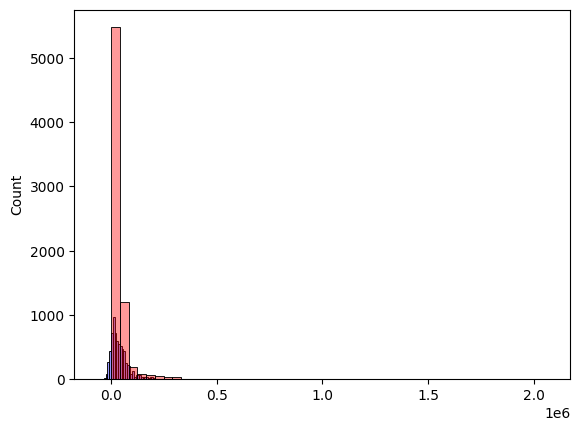

In [27]:
sns.histplot(y_pred, color='blue', alpha=0.4, bins=50,  label='y_pred')
sns.histplot(y_train_orig, color='red', alpha=0.4, bins=50, label='y_train_orig')

## Training with logarithmic transformation on prices

In [28]:
w_with_log_transform = linear_regression(X_train,log_y_train)
w_with_log_transform[0],w_with_log_transform[1:]

(np.float64(-180.8528902549315),
 array([ 9.43209513e-02,  3.80316024e-03,  7.39013429e-02, -2.35246490e-02,
        -2.85786636e-03,  1.10921411e-02, -4.88810772e-05]))

In [29]:
y_pred_log = X_train@w_with_log_transform[1:] + w_with_log_transform[0]

<Axes: ylabel='Count'>

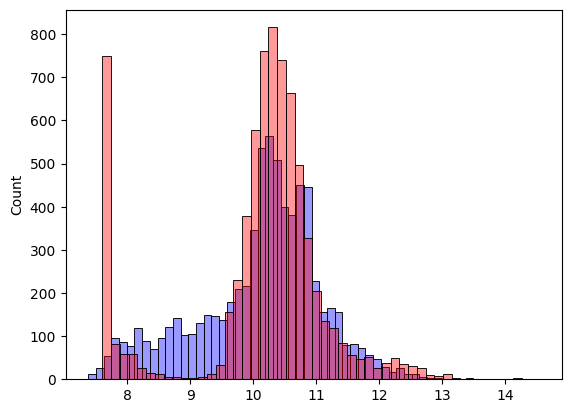

In [30]:
sns.histplot(y_pred_log,color='blue',alpha=0.4,bins=50)
sns.histplot(log_y_train,color='red',alpha=0.4,bins=50)

## using validation set

In [31]:
subset_val = df_val.values
y_pred_val_log = subset_val@w_with_log_transform[1:] + w_with_log_transform[0]

<Axes: ylabel='Count'>

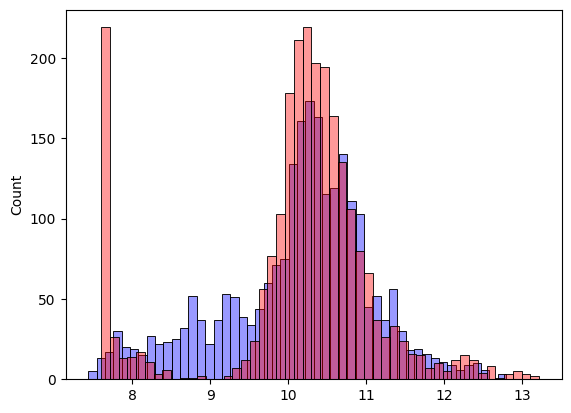

In [32]:
sns.histplot(y_pred_val_log,color='blue',alpha=0.4,bins=50)
sns.histplot(log_y_val,color='red',alpha=0.4,bins=50)

# RMSE

In [33]:
def root_mean_squared_error(y,y_pred):
    se = (y-y_pred)**2
    mse = se.mean()
    return np.sqrt(mse)

Without log transformation

In [34]:
root_mean_squared_error(y_train_orig,y_pred)

np.float64(47554.77710824525)

With log transformation

In [35]:
root_mean_squared_error(np.exp(log_y_train),np.exp(y_pred_log))

np.float64(45484.86037377263)

# Validation

## Without log transformation

In [36]:
X_val = df_val.values

In [37]:
y_val_pred = X_val@w[1:]+w[0]

In [38]:
root_mean_squared_error(y_val_orig,y_val_pred)

np.float64(32379.915609892465)

## With log transformation

In [39]:
log_y_val_pred = X_val@w_with_log_transform[1:]+w_with_log_transform[0]

In [40]:
root_mean_squared_error(np.exp(log_y_val),np.exp(log_y_val_pred))

np.float64(32417.132160022153)

# Simple feature engineering

In [41]:
def add_feature_age(df_train):
    df_dummy = df_train.copy()
    # so let's assume we are in this max year and calculate the age of every model
    df_dummy['year'] = df_train['year'].max()-df_dummy['year']
    df_dummy.rename(columns={'year':'age'},inplace=True)
    return df_dummy

In [42]:
new_df = add_feature_age(df_train)
new_df

,age,engine_hp,engine_cylinders,number_of_doors,highway_mpg,city_mpg,popularity
2735,9,148.0,4.0,2.0,33,24,1385
6720,5,132.0,4.0,4.0,32,25,2031
5878,1,148.0,4.0,4.0,37,28,640
11190,26,90.0,4.0,3.0,18,16,873
4554,0,385.0,8.0,4.0,21,15,5657
...,...,...,...,...,...,...,...
434,2,300.0,6.0,2.0,31,20,3916
1902,2,210.0,4.0,2.0,30,24,873
9334,2,285.0,6.0,4.0,22,17,549
5284,3,563.0,12.0,4.0,21,13,86


In [43]:
X_with_age = new_df.values

In [44]:
X_with_age

array([[9.000e+00, 1.480e+02, 4.000e+00, ..., 3.300e+01, 2.400e+01,
        1.385e+03],
       [5.000e+00, 1.320e+02, 4.000e+00, ..., 3.200e+01, 2.500e+01,
        2.031e+03],
       [1.000e+00, 1.480e+02, 4.000e+00, ..., 3.700e+01, 2.800e+01,
        6.400e+02],
       ...,
       [2.000e+00, 2.850e+02, 6.000e+00, ..., 2.200e+01, 1.700e+01,
        5.490e+02],
       [3.000e+00, 5.630e+02, 1.200e+01, ..., 2.100e+01, 1.300e+01,
        8.600e+01],
       [0.000e+00, 2.000e+02, 4.000e+00, ..., 3.100e+01, 2.200e+01,
        8.730e+02]], shape=(7150, 7))

## Training without log transformation

In [45]:
w_with_age = linear_regression(X_with_age,y_train_orig)
w_with_age[0],w_with_age[1:]

(np.float64(-89919.92729779411),
 array([-2.32105575e+01,  3.31902926e+02,  6.57468263e+03, -5.00407777e+03,
         4.92819018e+02,  1.04433399e+03, -3.27353453e+00]))

In [46]:
y_pred_with_age = X_with_age@w_with_age[1:] + w_with_age[0]

In [47]:
root_mean_squared_error(y_train_orig,y_pred_with_age)

np.float64(47554.77710824525)

<Axes: ylabel='Count'>

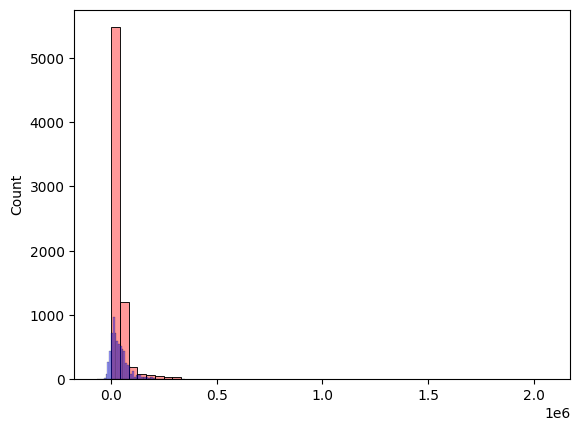

In [57]:
sns.histplot(y_train_orig,color='red',alpha=0.4,bins=50)
sns.histplot(y_pred_with_age,color='blue',alpha=0.4,bins=50)

## Training with log transformation

In [48]:
w_with_log_transform_and_age = linear_regression(X_with_age,log_y_train)
w_with_log_transform_and_age[0],w_with_log_transform_and_age[1:]

(np.float64(9.392468493632999),
 array([-9.43209513e-02,  3.80316024e-03,  7.39013429e-02, -2.35246490e-02,
        -2.85786636e-03,  1.10921411e-02, -4.88810772e-05]))

In [49]:
log_y_pred_with_age = X_with_age@w_with_log_transform_and_age[1:] + w_with_log_transform_and_age[0]

In [50]:
root_mean_squared_error(np.exp(log_y_train),np.exp(log_y_pred_with_age))

np.float64(45484.86037363226)

<Axes: ylabel='Count'>

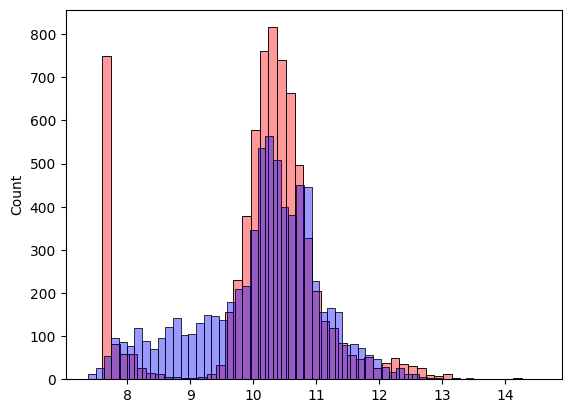

In [58]:
sns.histplot(log_y_train,color='red',alpha=0.4,bins=50)
sns.histplot(log_y_pred_with_age,color='blue',alpha=0.4,bins=50)

## Validation

In [51]:
X_val_with_age = add_feature_age(df_val).values

### Model that was trained without log transformation

In [52]:
y_val_pred_with_age = X_val_with_age@w_with_age[1:] +w_with_age[0]
root_mean_squared_error(y_val_orig,y_val_pred_with_age)

np.float64(32379.91560989289)

<Axes: ylabel='Count'>

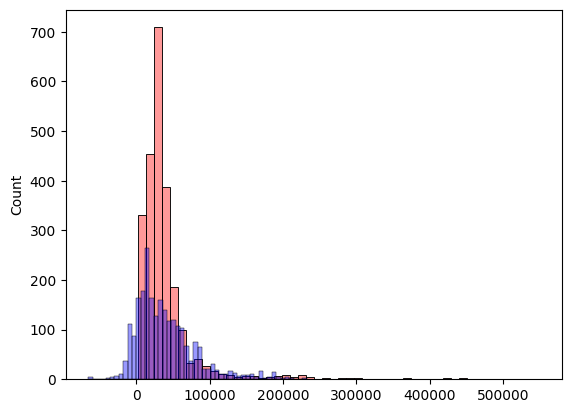

In [53]:
sns.histplot(y_val_orig,color='red',alpha=0.4,bins=50)
sns.histplot(y_val_pred_with_age,color='blue',alpha=0.4,bins=50)

### Model that was trained with log transformation

In [54]:
log_y_val_pred_with_age = X_val_with_age@w_with_log_transform_and_age[1:]+w_with_log_transform_and_age[0]
root_mean_squared_error(np.exp(log_y_val),np.exp(log_y_val_pred_with_age))

np.float64(32417.132160101253)

<Axes: ylabel='Count'>

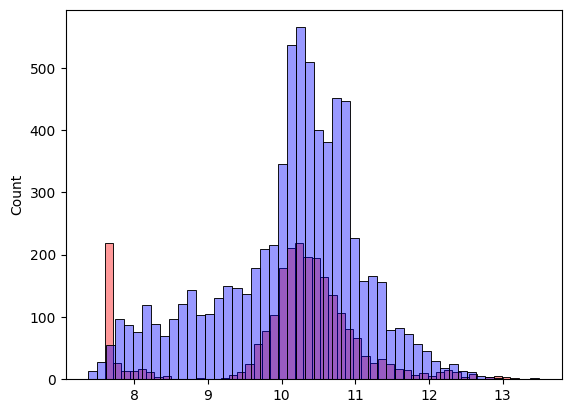

In [56]:
sns.histplot(log_y_val,color='red',alpha=0.4,bins=50)
sns.histplot(log_y_pred_with_age,color='blue',alpha=0.4,bins=50)